# Multi-stage continuous-flow manufacturing process

## Notebok 02 - Stage #1
![cover_img](images/cover_img.jpg "cover image assembly line")

## Brief Description

In the previous notebook 01, we had an overview about the data, we noticed that the system was not on a steady state and we understood that the data contains both baseline deviations and spike events which provide an extra contribution to the noise in the data.

## Aim
As the task is to make some predictions for Stage 1 and 2, in this notebook we will focus on Stage 1

## About the Dataset
This dataset can be accessed here: https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process

## Description of physical setup:		
- The data comes from a continuous flow process.		
- Sample rate is 1 Hz.
- In the first stage, Machines 1, 2,  and 3 operate in parallel, and feed their outputs into a step that combines the flows.		
- Output from the combiner is measured in 15 locations. **These measurements are the primary measurements to predict.**		
- Next, the output flows into a second stage, where Machines 4 and 5 process in series.		
- Measurements are made again in the same 15 locations. **These are the secondary measurements to predict**.		
- Measurements are noisy.		
- Each measurement also has a target or Setpoint (setpoints are included in the first row of data).		
- The goal is to predict the measurements (or the error versus setpoints) for as many of the 15 measurements as possible.		
- Some measurements will be more predictable than others!		
- **Prediction of measurements after the first stage are the primary interest.**		
- **Prediction of measurements after the second stage are nice-to-have but the data is much more noisy.**	
		
## Naming conventions

| **Column Label Sufix** | **Meaning** |
|------------------------|-------------|
|*~.C.Setpoint*          | Setpoint for Controlled variable |
|*~.C.Actual*            | Actual value of Controlled variable |
|*~.U.Actual*            | Actual value of Uncontrolled variable |
|*Others*                | Environmental or raw material variables, States / events, etc. |

---
		
|**Start col**|**End col**|**Description**|
|-------------|-----------|---------------|
|0            |0          |Time stamp     |
|1	          |2	      |Factory ambient conditions |
|3	          |6	      |First stage, Machine 1, raw material properties (material going in to Machine 1) |
|7	          |14	      |First stage, Machine 1 process variables |
|15	          |18	      |First stage, Machine 2, raw material properties (material going in to Machine 2) |
|19	          |26	      |First stage, Machine 2 process variables |
|27	          |30	      |First stage, Machine 3, raw material properties (material going in to Machine 3) |
|31	          |38	      |First stage, Machine 3 process variables |
|39	          |41	      |Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3. |
|42	          |71	      |PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each |
|72	          |78	      |Second stage, Machine 4 process variables |
|79	          |85	      |Second stage, Machine 5 process variables |
|86	          |115        |SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each|


## Data Load

In [2]:
# import releavant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Get the data
df = pd.read_csv("data\continuous_factory_process.csv")

# Get the shape of the dataframe
print("The shape of the df is:", df.shape, "\n")

# Drop columns pertaining Stage2, i.e. exclude Machine4- and Machine5- and all Stage2-labeled columns
for col in df:
    if col.startswith("Machine4") or col.startswith("Machine5") or col.startswith("Stage2"):
        df.drop(col, axis=1, inplace=True)

# Print out the column names
col_names = ""
for i, col in enumerate(df.columns):
    col_names = col_names + str(i) + " | " + col + "   "
print(col_names)

# Get the shape of the dataframe
print("\nThe shape of the df is:", df.shape, "\n")

The shape of the df is: (14088, 116) 

0 | time_stamp   1 | AmbientConditions.AmbientHumidity.U.Actual   2 | AmbientConditions.AmbientTemperature.U.Actual   3 | Machine1.RawMaterial.Property1   4 | Machine1.RawMaterial.Property2   5 | Machine1.RawMaterial.Property3   6 | Machine1.RawMaterial.Property4   7 | Machine1.RawMaterialFeederParameter.U.Actual   8 | Machine1.Zone1Temperature.C.Actual   9 | Machine1.Zone2Temperature.C.Actual   10 | Machine1.MotorAmperage.U.Actual   11 | Machine1.MotorRPM.C.Actual   12 | Machine1.MaterialPressure.U.Actual   13 | Machine1.MaterialTemperature.U.Actual   14 | Machine1.ExitZoneTemperature.C.Actual   15 | Machine2.RawMaterial.Property1   16 | Machine2.RawMaterial.Property2   17 | Machine2.RawMaterial.Property3   18 | Machine2.RawMaterial.Property4   19 | Machine2.RawMaterialFeederParameter.U.Actual   20 | Machine2.Zone1Temperature.C.Actual   21 | Machine2.Zone2Temperature.C.Actual   22 | Machine2.MotorAmperage.U.Actual   23 | Machine2.MotorRPM.C.Actua

In [4]:
# We know that setpoint values are typically constant, so let's exclude those as they do not provide information for the model
for col in df:
    if col.endswith("Setpoint"):
        df.drop(col, axis=1, inplace=True)

# Print out the column names
col_names = ""
for i, col in enumerate(df.columns):
    col_names = col_names + str(i) + " | " + col + "   "
print(col_names)

# Get the shape of the dataframe
print("\nThe shape of the df is:", df.shape, "\n")

0 | time_stamp   1 | AmbientConditions.AmbientHumidity.U.Actual   2 | AmbientConditions.AmbientTemperature.U.Actual   3 | Machine1.RawMaterial.Property1   4 | Machine1.RawMaterial.Property2   5 | Machine1.RawMaterial.Property3   6 | Machine1.RawMaterial.Property4   7 | Machine1.RawMaterialFeederParameter.U.Actual   8 | Machine1.Zone1Temperature.C.Actual   9 | Machine1.Zone2Temperature.C.Actual   10 | Machine1.MotorAmperage.U.Actual   11 | Machine1.MotorRPM.C.Actual   12 | Machine1.MaterialPressure.U.Actual   13 | Machine1.MaterialTemperature.U.Actual   14 | Machine1.ExitZoneTemperature.C.Actual   15 | Machine2.RawMaterial.Property1   16 | Machine2.RawMaterial.Property2   17 | Machine2.RawMaterial.Property3   18 | Machine2.RawMaterial.Property4   19 | Machine2.RawMaterialFeederParameter.U.Actual   20 | Machine2.Zone1Temperature.C.Actual   21 | Machine2.Zone2Temperature.C.Actual   22 | Machine2.MotorAmperage.U.Actual   23 | Machine2.MotorRPM.C.Actual   24 | Machine2.MaterialPressure.U.Ac

## Correlations

Text(0.5, 1.0, 'Correlation of input features with output features')

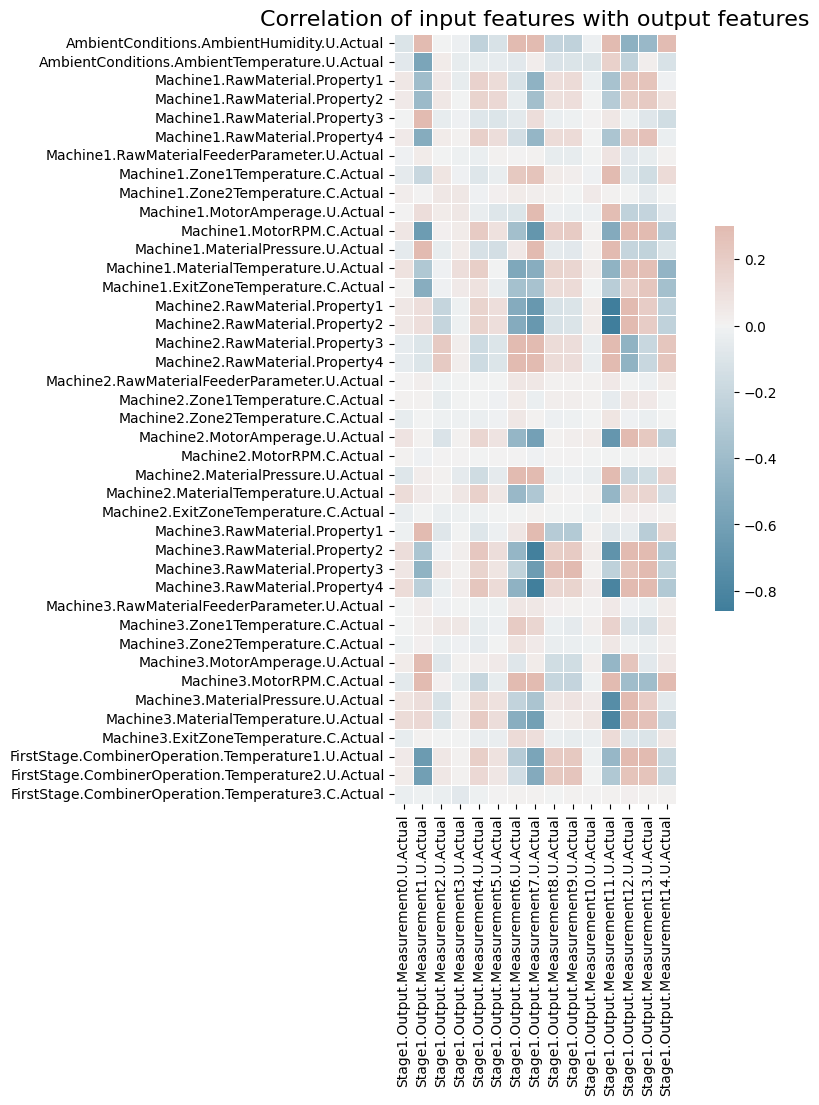

In [29]:
# Let's check for correlations (do not select the time_stamp feature)
corr = df.iloc[:,1:].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap to visualize input variables and how they correlate with output variables
sns.heatmap(corr.iloc[0:41,41:58], cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Correlation of input features with output features", size=16)

It appears that some output features seem to strongly correlate with input variables (e.g. measurements 1, 6, 7, 11), while other variables don't seem to have their output determined by a single controlled or uncontrolled input variable, but may eventually be dependent on a combination of those variables (e.g. measurements 0, 3 and 10).

However, it is important to realize that this form of correlation does not assume the existance of any lag, but because this is a continuous process, where events on machines 1, 2 or 3 may only be felt sometime after in the output variables, we know there has to be a lag, we just do not know the details of that. 

> This makes this exercise rather controversial because for any given output variable measured at any given moment, the only association that you can make with the input variables are those that occured at the same time the output variable was measured. When the time comes to test and validate out model, we can only rely on the numbers that we are given.

<Axes: >

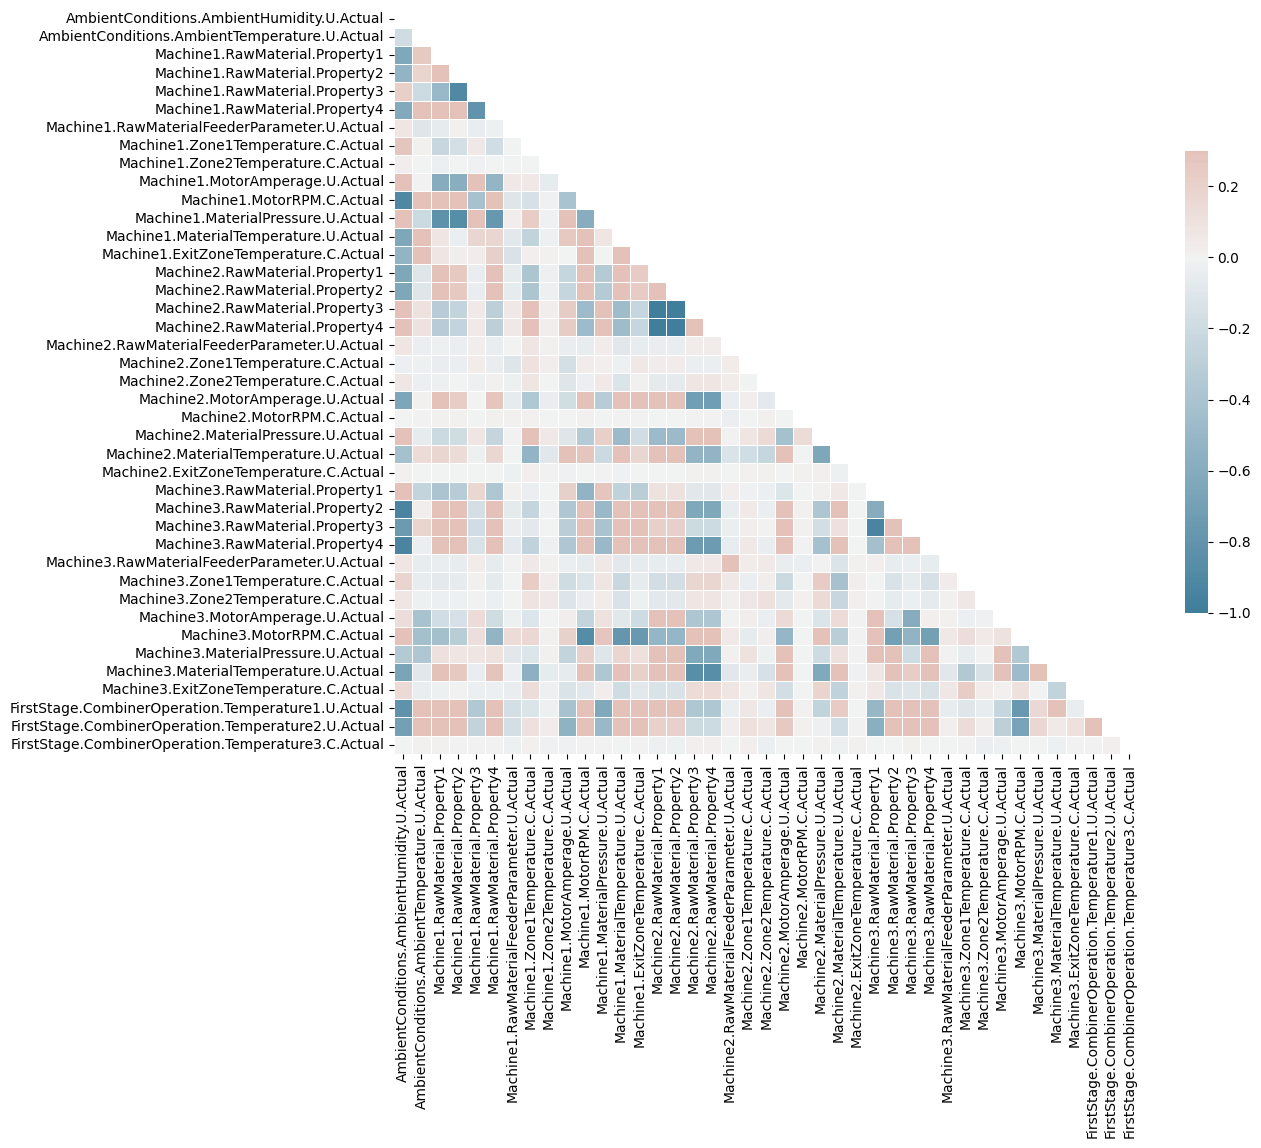

In [26]:
# Let's visualize correlations again, but this we look at possible correlations between input variables.

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.iloc[0:41,0:41], dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[0:41,0:41], cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = mask)


The importance of this is to detect possible redundancies in the predictor variables. There can be that instead of a sensor,
we may have two sensors measuring the exact same thing, or two properties that are very much interdependent. From the plot above we can see that Machine3.RawMaterial.Property 2, 3 and 4 are very much inversely correlated with AmbientConditions.AmbientHumidty.U.Actual.

Features that correlate well with other features:
Machine3.RawMaterial.Properties 2 throguh 3 correlate very much with eachother.
Machine2.RawMaterial.Properties 1 & 2
Machine2.RawMaterial.Properties 3 & 4
Machine1.RawMaterial.Properties 1 & 2

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

corr_cols1 = ["Machine2.RawMaterial.Property1",
             "Machine2.RawMaterial.Property2",
             "Machine2.RawMaterial.Property3",
             "Machine2.RawMaterial.Property4",
             "Machine3.RawMaterial.Property1",
             "Machine3.RawMaterial.Property2",
             "Machine3.RawMaterial.Property3",
             "Machine3.RawMaterial.Property4",
             "Machine1.RawMaterial.Property1",
             "Machine1.RawMaterial.Property2",
             "Machine1.RawMaterial.Property3",
             "Machine1.RawMaterial.Property4"]

std_pca = Pipeline([("std", StandardScaler()),
                    ("pca", PCA(n_components=0.9)),
                    ])

In [48]:
pca_cols = std_pca.fit_transform(df.loc[:,corr_cols1])
pca_cols.shape

(14088, 3)

In [4]:
# Let's see which column has an "Object" data type:
for col in df.columns:
    if df[col].dtypes == "object":
        print(col)

# Note: only the "time_stamp" holds non-numeric data type.

time_stamp


In [5]:
# Let's see if there are any NaNs and Nulls
print("Number of NaNs in the dataset is: {}.".format(df.isna().sum().sum()))
print("Number of Nulls in the dataset is: {}.".format(df.isnull().sum().sum()))

# Note: Excellent, the dataset is to a good extent clean.

Number of NaNs in the dataset is: 0.
Number of Nulls in the dataset is: 0.


There are 47 features that have elements with the value of "Zero"


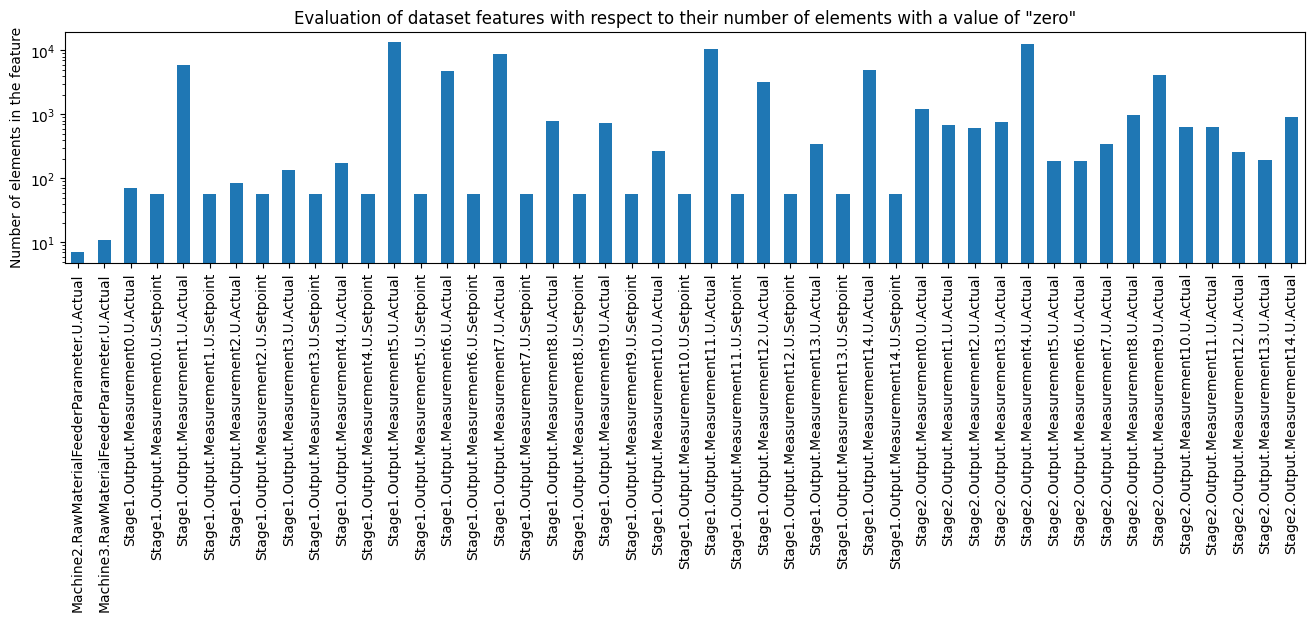

In [6]:
# Let's also get an impression on how many entries with the value of "zero" in those Features that have them.
zero_nr = []
zero_cols = []
for col in df.columns:
    if df[col].dtypes != "object":
        mask = df[col] == 0
        flag_zero = mask.sum()
        if flag_zero > 0:
            zero_nr += [flag_zero]
            zero_cols += [col]
            #print(col, " >>> ", mask.sum())

zero_series = pd.Series(zero_nr, index = zero_cols)
zero_series.plot(kind = "bar", figsize=(16,3))
plt.yscale("log")
plt.ylabel("Number of elements in the feature")
plt.title("Evaluation of dataset features with respect to their number of elements with a value of \"zero\"")

print("There are {} features that have elements with the value of \"Zero\"".format(zero_series.shape[0]))

# Note: Out of 116 columns, 47 of them have Zeros, some of them reaching close to 1000 elements in a feature


### Conclusion
> - The dataset appears to be well kept, we do not have to deal with missing values and the only "object" data-type is the time_stamp feature, which we can later convert to datetime.
>  - There are many features containing elements with the value of "zero" - these can be normal values, or can be outliers and should be investigated further.
> - Naming the "setpoint" features as such is a bit misleading, as they are associated with uncontrolled variables (denoted by the "U" in column names), they would be better named as "Target" variables.

## A first look at the data

I find it to be useful to begin any data-analysis project by simply appreciating how the data looks like, i.e. visualizing it. While you could immediately start making histograms, and checking all sorts of plots and correlative analysis, I tend to think that it pays off to spend some time understanding how the different input and output variables fluctuate across the dataset. So, let's plot some data to have an impression on how the data looks like so that hopefully we may develop some understanding on how each machine is operating.

### Machine Zone Temperatures

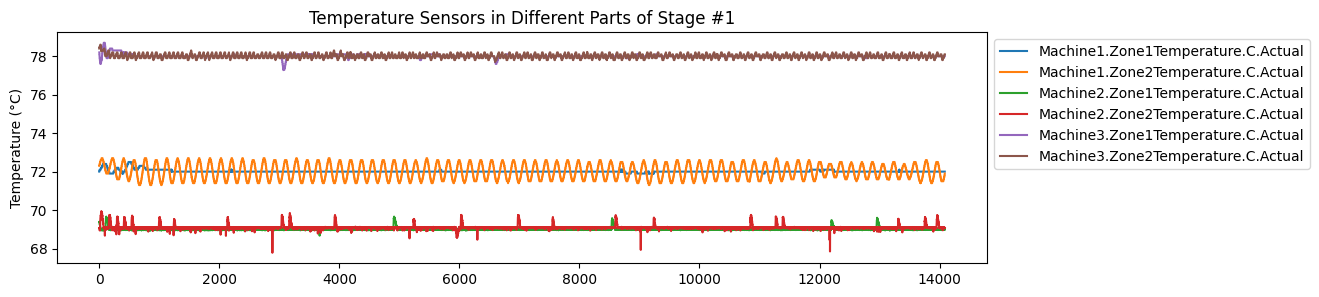

In [7]:
# Select for each of the first 3 machines the Temperature variables for each zone.
df.iloc[:,[8,9,20,21, 32, 33]].plot(figsize=(12,3),
                            title="Temperature Sensors in Different Parts of Stage #1",
                            ylabel = "Temperature (°C)",
                            legend = True);

plt.legend(bbox_to_anchor=(1, 1));

# Note: For each machine the average temperature of Zones 1 and 2 are similar.
# Machine 1 shows higher levels of noise, but average is consistent.
# Machine 2 shows spikes.

### Machine MotorRPM

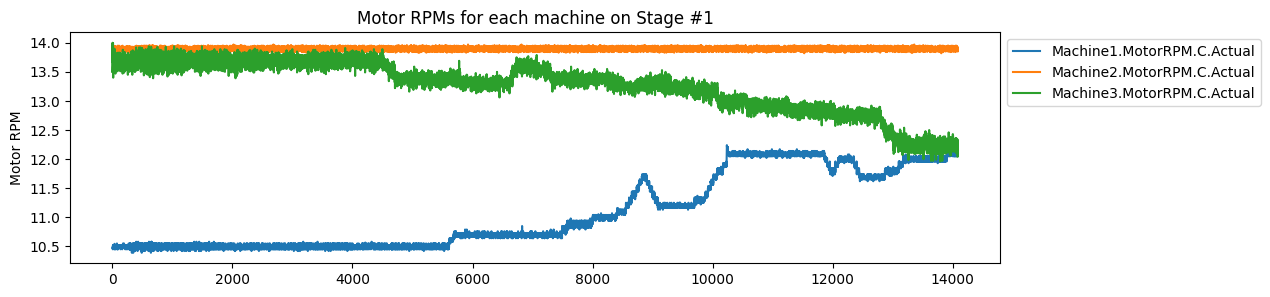

In [8]:
# Let's look at MotorRPM

select_cols = []
for col in df.columns:
    if "MotorRPM" in col:
        select_cols += [df.columns.get_loc(col)]

df.iloc[:,select_cols].plot(figsize=(12,3),
                            title="Motor RPMs for each machine on Stage #1",
                            ylabel = "Motor RPM",
                            legend = True);

plt.legend(bbox_to_anchor=(1, 1));

# Note: There is drift in MotorRPM for machines 1 and 3, which appear to be anti-correlated.

### Machine MotorAmperage

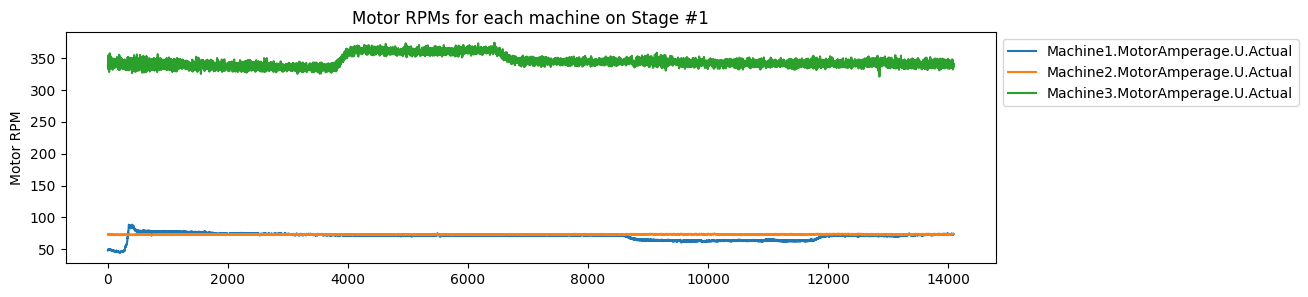

In [9]:
# Let's look at MotorAmperage

select_cols = []
for col in df.columns:
    if "MotorAmperage" in col:
        select_cols += [df.columns.get_loc(col)]

df.iloc[:,select_cols].plot(figsize=(12,3),
                            title="Motor RPMs for each machine on Stage #1",
                            ylabel = "Motor RPM",
                            legend = True);

plt.legend(bbox_to_anchor=(1, 1));

# Note: MotorAmperage is unavailable for Machines 4 and 5

### Material Pressure

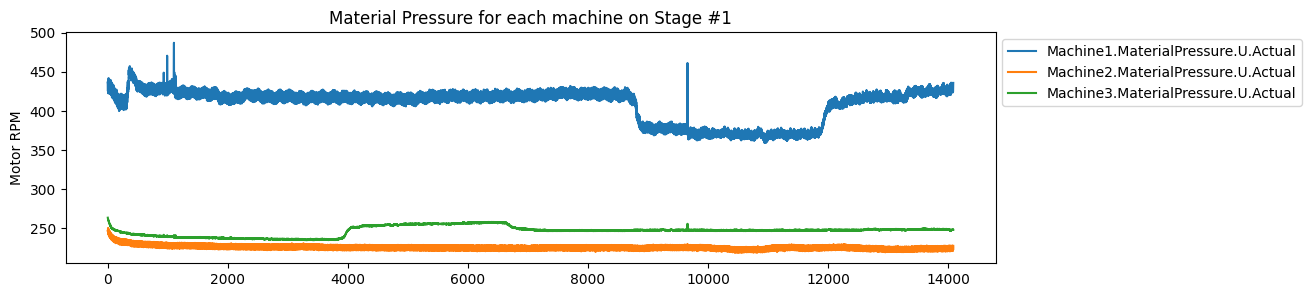

In [10]:
# Let's look at Material Pressure

select_cols = []
for col in df.columns:
    if "MaterialPressure" in col:
        select_cols += [df.columns.get_loc(col)]

df.iloc[:,select_cols].plot(figsize=(12,3),
                            title="Material Pressure for each machine on Stage #1",
                            ylabel = "Motor RPM",
                            legend = True);

plt.legend(bbox_to_anchor=(1, 1));

# Note: MaterialPressure and MotorAmperage appear to be highly correlated.

### RawMaterial.Property (1 through 4)

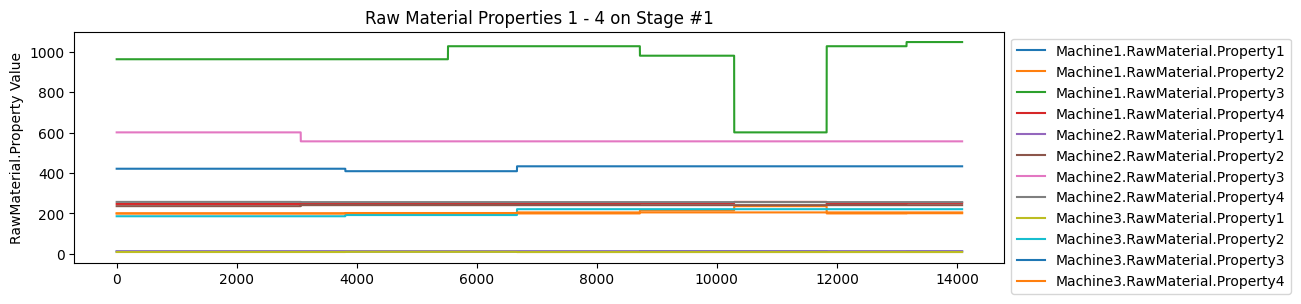

In [11]:
# Let's look at RawMaterial.Property 1 throguh 4 for each machine

select_cols = []
for col in df.columns:
    if "RawMaterial.Property" in col:
        select_cols += [df.columns.get_loc(col)]

df.iloc[:,select_cols].plot(figsize=(12,3),
                            title="Raw Material Properties 1 - 4 on Stage #1",
                            ylabel = "RawMaterial.Property Value",
                            legend = True);

plt.legend(bbox_to_anchor=(1, 1));

# Note: The values of the proerties are pretty stable but the traces are populated by step events, rather than noise, spiky baselines.

### Conclusion
> - The data contains different types of noise (drifts, spikes, step changes)
> - The data does not seem to describe a steady-state process, and strong deviations from the baseline are observed, with many variables evidencing noticebeale drifts away from the values recorded at the start of the data.
> - Some features appear to be (anti-)correlated.

## Understanding the output data: "Setpoint" vs. "Actual"

In this dataset the variables named "Setpoint" correspond to the target outcome that the manufacturer aims for.
The closer the "Actual" measurement is to the "Setpoint" value, the closer the product is to the desired outcome. Thus, it would make sense that each setpoint feature to have always the same value.

In [12]:
# Let's create a dataframe that holds just those varaibles.
df_setpoint = pd.DataFrame()

for col in df.columns:
    if col.endswith(".Setpoint"):
        df_setpoint = pd.concat([df_setpoint, df.loc[:,col]], axis = 1)

# Let's check if setpoint values are unique for each column
for col in df_setpoint:
    print(col, df_setpoint.loc[:,col].unique())

# Note: Unfortunately in Stage1, we have two setpoint values and one of them is consistently "zero"

Stage1.Output.Measurement0.U.Setpoint [13.75  0.  ]
Stage1.Output.Measurement1.U.Setpoint [22.74  0.  ]
Stage1.Output.Measurement2.U.Setpoint [13.02  0.  ]
Stage1.Output.Measurement3.U.Setpoint [21.88  0.  ]
Stage1.Output.Measurement4.U.Setpoint [32.55  0.  ]
Stage1.Output.Measurement5.U.Setpoint [2.74 0.  ]
Stage1.Output.Measurement6.U.Setpoint [4.25 0.  ]
Stage1.Output.Measurement7.U.Setpoint [2.97 0.  ]
Stage1.Output.Measurement8.U.Setpoint [21.3  0. ]
Stage1.Output.Measurement9.U.Setpoint [19.52  0.  ]
Stage1.Output.Measurement10.U.Setpoint [8.65 0.  ]
Stage1.Output.Measurement11.U.Setpoint [6.16 0.  ]
Stage1.Output.Measurement12.U.Setpoint [2.02 0.  ]
Stage1.Output.Measurement13.U.Setpoint [3.16 0.  ]
Stage1.Output.Measurement14.U.Setpoint [17.72  0.  ]
Stage2.Output.Measurement0.U.Setpoint [12.05]
Stage2.Output.Measurement1.U.Setpoint [11.71]
Stage2.Output.Measurement2.U.Setpoint [11]
Stage2.Output.Measurement3.U.Setpoint [20.73]
Stage2.Output.Measurement4.U.Setpoint [31.36]
Stag

In [13]:
#Let's examine the proportions of the two different setpoint values in Stage1
for idx, col in enumerate(df):
    if col.startswith("Stage1") and col.endswith("Setpoint"):
        print(">>>> Col nr:", idx, " | ")
        print(df[col].value_counts(normalize=False), "\n")

# Note: There is a consistent number of 56 entries for all columns with the value of "zero".
# This means that for a total  of 56 seconds some machines were set to operate at "zero".

>>>> Col nr: 43  | 
Stage1.Output.Measurement0.U.Setpoint
13.75    14032
0.00        56
Name: count, dtype: int64 

>>>> Col nr: 45  | 
Stage1.Output.Measurement1.U.Setpoint
22.74    14032
0.00        56
Name: count, dtype: int64 

>>>> Col nr: 47  | 
Stage1.Output.Measurement2.U.Setpoint
13.02    14032
0.00        56
Name: count, dtype: int64 

>>>> Col nr: 49  | 
Stage1.Output.Measurement3.U.Setpoint
21.88    14032
0.00        56
Name: count, dtype: int64 

>>>> Col nr: 51  | 
Stage1.Output.Measurement4.U.Setpoint
32.55    14032
0.00        56
Name: count, dtype: int64 

>>>> Col nr: 53  | 
Stage1.Output.Measurement5.U.Setpoint
2.74    14032
0.00       56
Name: count, dtype: int64 

>>>> Col nr: 55  | 
Stage1.Output.Measurement6.U.Setpoint
4.25    14032
0.00       56
Name: count, dtype: int64 

>>>> Col nr: 57  | 
Stage1.Output.Measurement7.U.Setpoint
2.97    14032
0.00       56
Name: count, dtype: int64 

>>>> Col nr: 59  | 
Stage1.Output.Measurement8.U.Setpoint
21.3    14032
0.0   

In [14]:
# Check the entries (rows) where the value of zero is given to any of the features

for col in df_setpoint.columns:
    if col.startswith("Stage1"):
        mask = df.loc[:,col] == 0
        select_rows = df_setpoint.loc[mask,:].index
        print(col)
        print(select_rows)

# Note: There where two periods where the setpoint values were set at 0:
#   --- between 3717 and 3751, and
#   --- between 4221 and 4241

Stage1.Output.Measurement0.U.Setpoint
Index([3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728,
       3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740,
       3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 4221,
       4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233,
       4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241],
      dtype='int64')
Stage1.Output.Measurement1.U.Setpoint
Index([3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728,
       3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740,
       3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 4221,
       4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233,
       4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241],
      dtype='int64')
Stage1.Output.Measurement2.U.Setpoint
Index([3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728,
       3729, 3730, 37

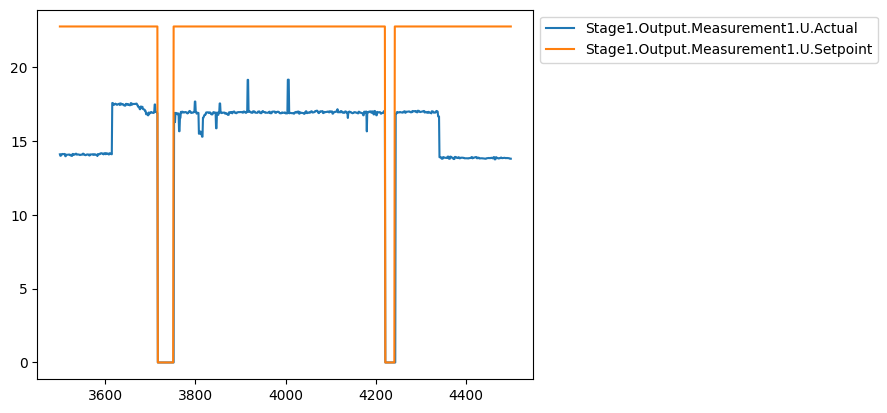

In [15]:
#plot data between 3500 and 4500 for and for any given variable contrast the Actual with the Setpoint
df.iloc[3500:4500,44:46].plot()
plt.legend(bbox_to_anchor=(1, 1));

# Note: Indeed we can see two periods where the setpoint values drop to "zero",
# which was accompanied by a drop to "zero" of the corresponding "Actual" measurement.
# This could have been a power interruption, or something similar.
# It is also interesting that there are significant level changes in the Actual variable which
# are not correlated with changes in the Setpoint, suggesting that this feature is being affected
# by something else, other than its setpoint value.

In [16]:
# Let's make pairs of variables such that "xxxx.Actual" is paired with "xxxx.Setpoint"
col_pairs = []
for col in df.columns:
    if col.endswith("Setpoint"):
        var_name = col[0:-len("Setpoint")]
        col_actual = var_name + "Actual"
        if col_actual in df.columns:
            pair = [col_actual, col]
            col_pairs += [pair]

print("There are a total of {} Actual/Setpoint column pairs.\n".format(len(col_pairs)))
print(col_pairs[0:15])
print("")
print(col_pairs[15:])

There are a total of 30 Actual/Setpoint column pairs.

[['Stage1.Output.Measurement0.U.Actual', 'Stage1.Output.Measurement0.U.Setpoint'], ['Stage1.Output.Measurement1.U.Actual', 'Stage1.Output.Measurement1.U.Setpoint'], ['Stage1.Output.Measurement2.U.Actual', 'Stage1.Output.Measurement2.U.Setpoint'], ['Stage1.Output.Measurement3.U.Actual', 'Stage1.Output.Measurement3.U.Setpoint'], ['Stage1.Output.Measurement4.U.Actual', 'Stage1.Output.Measurement4.U.Setpoint'], ['Stage1.Output.Measurement5.U.Actual', 'Stage1.Output.Measurement5.U.Setpoint'], ['Stage1.Output.Measurement6.U.Actual', 'Stage1.Output.Measurement6.U.Setpoint'], ['Stage1.Output.Measurement7.U.Actual', 'Stage1.Output.Measurement7.U.Setpoint'], ['Stage1.Output.Measurement8.U.Actual', 'Stage1.Output.Measurement8.U.Setpoint'], ['Stage1.Output.Measurement9.U.Actual', 'Stage1.Output.Measurement9.U.Setpoint'], ['Stage1.Output.Measurement10.U.Actual', 'Stage1.Output.Measurement10.U.Setpoint'], ['Stage1.Output.Measurement11.U.Actual',

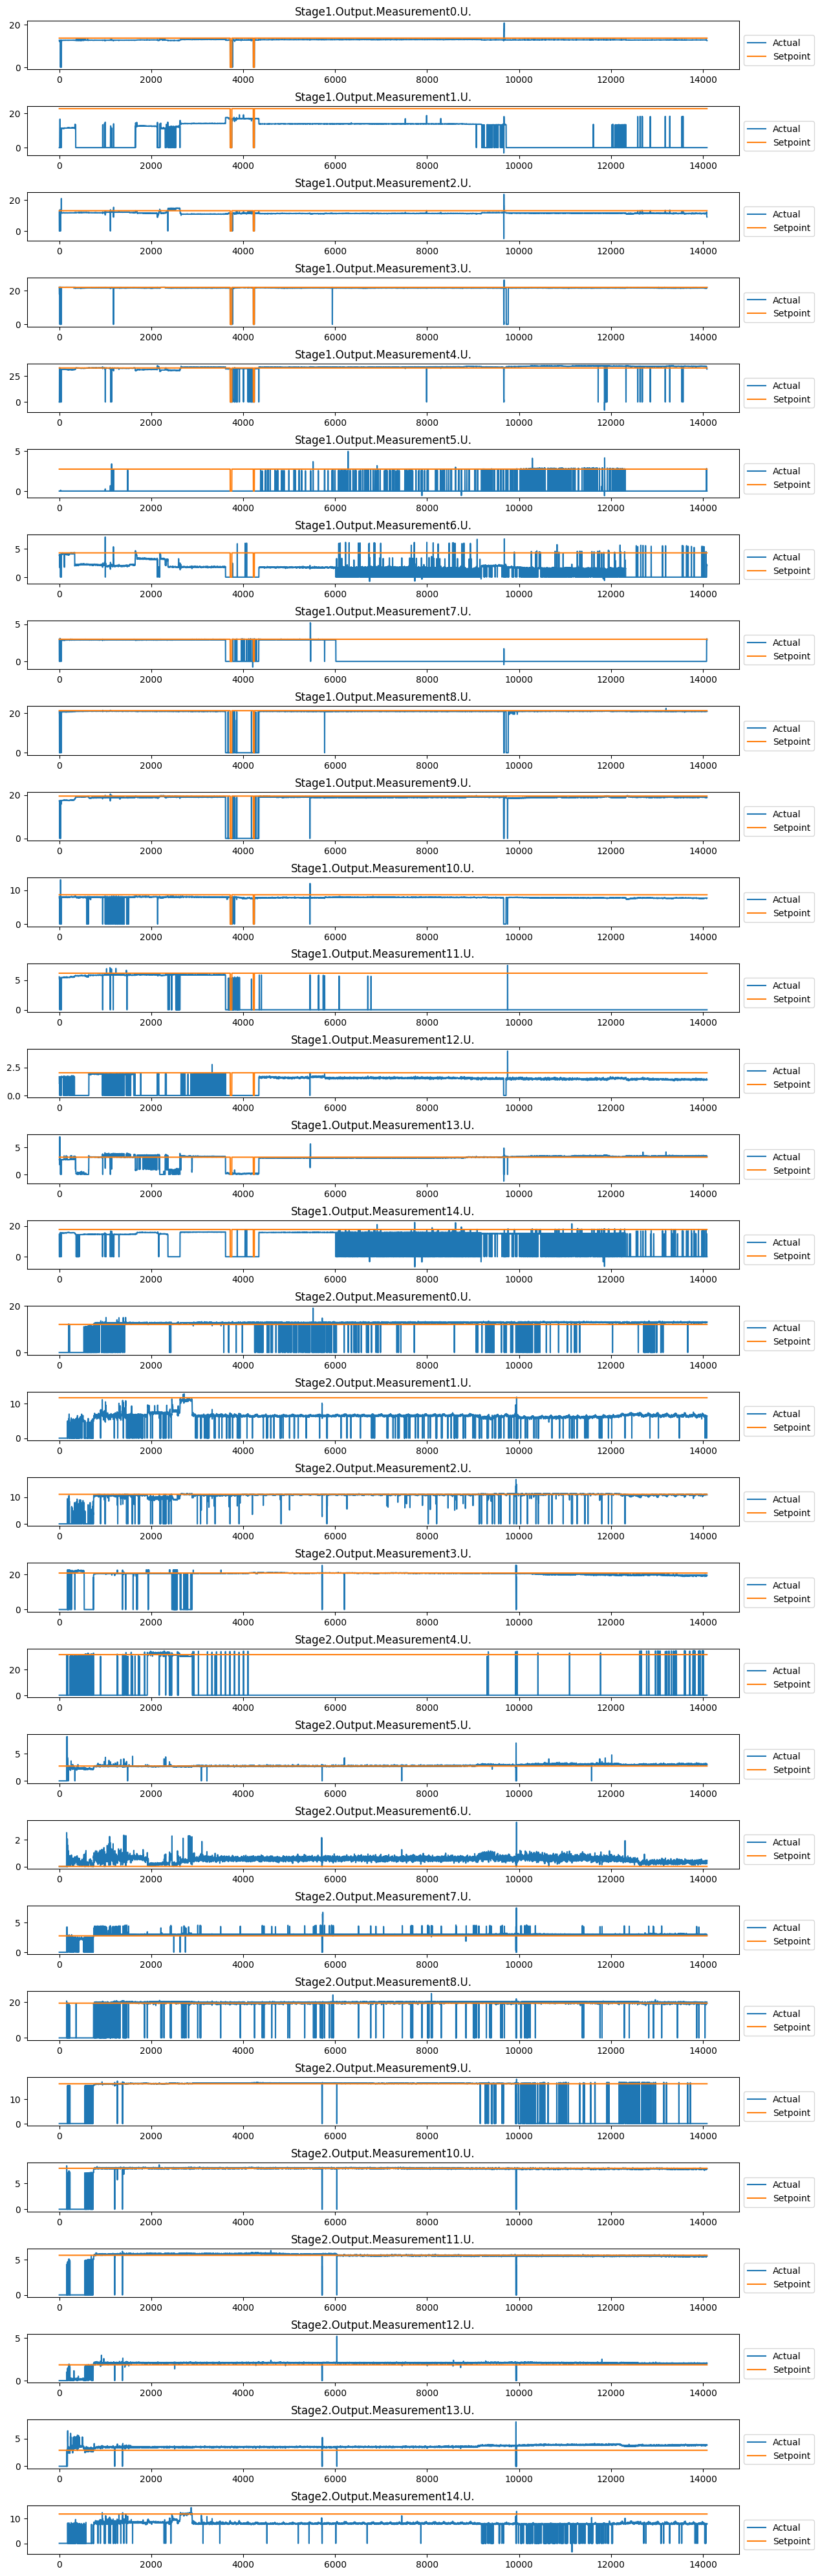

In [17]:
# Let's plot the pairs of "Actual" and "Setpoint" variables:

fig, ax = plt.subplots(nrows = 30, ncols = 1, figsize=(12,40))
fig.tight_layout(pad=2.0)
for i, row in enumerate(ax):
    df.loc[:, col_pairs[i]].plot(ax = row)
    # set titles
    plot_title = col_pairs[i][0][0:-len("Actual")]    
    row.set_title(plot_title)
    #set legends
    legend = ["Actual", "Setpoint"]
    row.legend(legend, bbox_to_anchor=(1,0), loc="lower left")

The traces suggest that there is a considerable deviation between setpoint and actual measured values.

These deviations take two distinct shapes:
- **baseline deviations** which are are deviations that exhibit a trend, and
- **spike events**, which are suddent changes in the recorded values, often appearing in rapid succession, or bursts.

Many of the "Actual" traces hold at some point the value of "zero" while the setpoint values typically lie far away from it. There are only a few cases where the value of "zero" is not spike-like, but is instead consistent. This spike-like activity in the traces whereby a value drops to zero and immediately returns back up is suggestive of some interruption in the normal measurements of the sample, either by absence of the sample, or some fault in the sensor that transmits data in an interrupted way. 

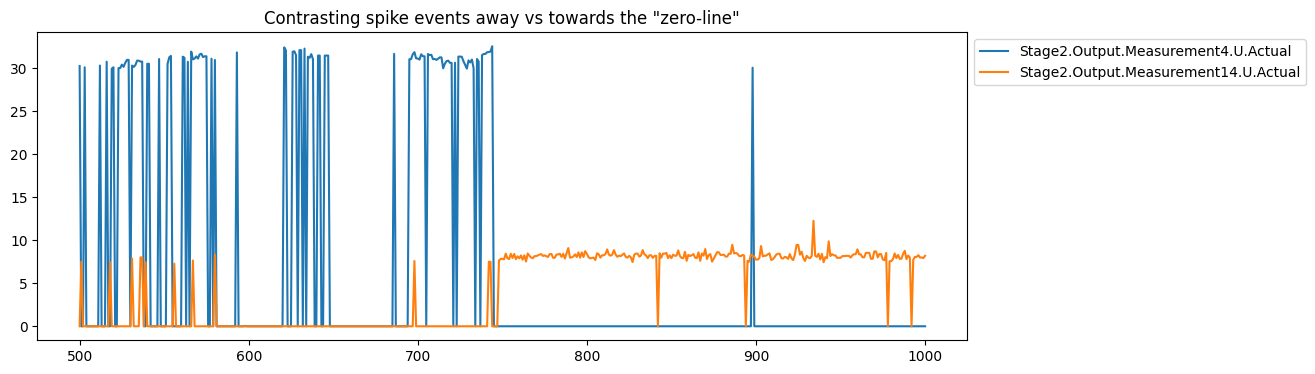

In [53]:
# Let's observe the spikes a bit more carefully.
df.loc[500:1000,["Stage2.Output.Measurement4.U.Actual", "Stage2.Output.Measurement14.U.Actual"]].plot(figsize=(12,4))
plt.legend(bbox_to_anchor=(1, 1));
plt.title("Contrasting spike events away vs towards the \"zero-line\"");

# Note: Depending on the trace, and on the region of the trace, the spike can either be steming from the "zero" line, or going towards it.

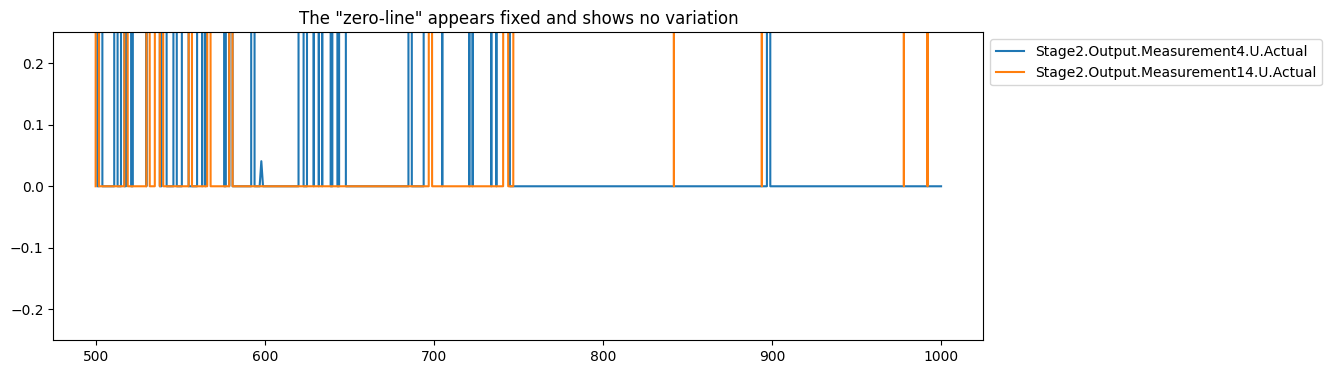

In [54]:
# Let's observe the spikes a bit more carefully.
df.loc[500:1000,["Stage2.Output.Measurement4.U.Actual", "Stage2.Output.Measurement14.U.Actual"]].plot(figsize=(12,4), ylim=[-0.25,0.25])
plt.legend(bbox_to_anchor=(1, 1));

plt.title("The \"zero-line\" appears fixed and shows no variation");

- Spikes that point away from the zero-line reach values that are distributed about a given value close to the setpoint.
- By contrast, spikes that point towards the "zero-line" do not seem to oscilate around "zero", instead they are typically fixed at exactly "zero".
- This suggests that "zero" is not a measurement value, but a meausurement failure. In fact, it is not uncommon for sensors not detecting anything to report "zero" as an output ('though more modern sensors will report some form of error).

In [19]:
# Let's understand how different "Actual" relative to "Setpoint" by 
# creating a "diff" feature that will hold the absolute difference between the two.
for var in col_pairs:
    var_dif = abs(df[var[0]]-df[var[1]])
    diff_col_name = var[0][0:-len("Actual")] + "diff"
    df[diff_col_name] = var_dif

df.iloc[:,-30:]

,Stage1.Output.Measurement0.U.diff,Stage1.Output.Measurement1.U.diff,Stage1.Output.Measurement2.U.diff,Stage1.Output.Measurement3.U.diff,Stage1.Output.Measurement4.U.diff,Stage1.Output.Measurement5.U.diff,Stage1.Output.Measurement6.U.diff,Stage1.Output.Measurement7.U.diff,Stage1.Output.Measurement8.U.diff,Stage1.Output.Measurement9.U.diff,...,Stage2.Output.Measurement5.U.diff,Stage2.Output.Measurement6.U.diff,Stage2.Output.Measurement7.U.diff,Stage2.Output.Measurement8.U.diff,Stage2.Output.Measurement9.U.diff,Stage2.Output.Measurement10.U.diff,Stage2.Output.Measurement11.U.diff,Stage2.Output.Measurement12.U.diff,Stage2.Output.Measurement13.U.diff,Stage2.Output.Measurement14.U.diff
0,1.03,22.74,0.86,0.09,32.55,2.74,0.43,0.03,0.48,2.22,...,2.71,0.01,2.75,19.39,16.47,7.93,5.65,1.85,2.89,11.71
1,1.41,22.74,13.02,4.10,32.55,2.74,0.28,2.97,1.65,2.21,...,2.71,0.01,2.75,19.39,16.47,7.93,5.65,1.85,2.89,11.71
2,1.41,22.74,13.02,4.10,32.55,2.74,0.28,2.97,1.65,2.21,...,2.71,0.01,2.75,19.39,16.47,7.93,5.65,1.85,2.89,11.71
3,1.41,22.74,13.02,4.10,32.55,2.74,0.28,2.97,1.65,2.21,...,2.71,0.01,2.75,19.39,16.47,7.93,5.65,1.85,2.89,11.71
4,1.46,22.74,13.02,4.05,1.11,2.74,0.38,2.97,21.30,2.22,...,2.71,0.01,2.75,19.39,16.47,7.93,5.65,1.85,2.89,11.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,1.14,22.74,3.88,0.38,1.00,2.74,2.15,0.06,0.42,0.57,...,0.38,0.22,0.22,0.69,16.47,0.06,0.12,0.22,0.91,4.15
14084,1.14,22.74,3.88,0.38,1.00,2.74,2.15,0.06,0.42,0.57,...,0.23,0.20,0.22,0.18,16.47,0.08,0.17,0.16,0.90,3.95
14085,1.14,22.74,3.88,0.38,1.00,2.74,2.15,0.06,0.42,0.57,...,0.32,0.26,0.21,0.21,16.47,0.00,0.11,0.21,0.94,4.05
14086,1.17,22.74,4.03,0.04,1.00,2.74,2.20,0.06,0.39,0.68,...,0.25,0.45,0.17,0.09,16.47,0.08,0.14,0.20,0.94,3.84


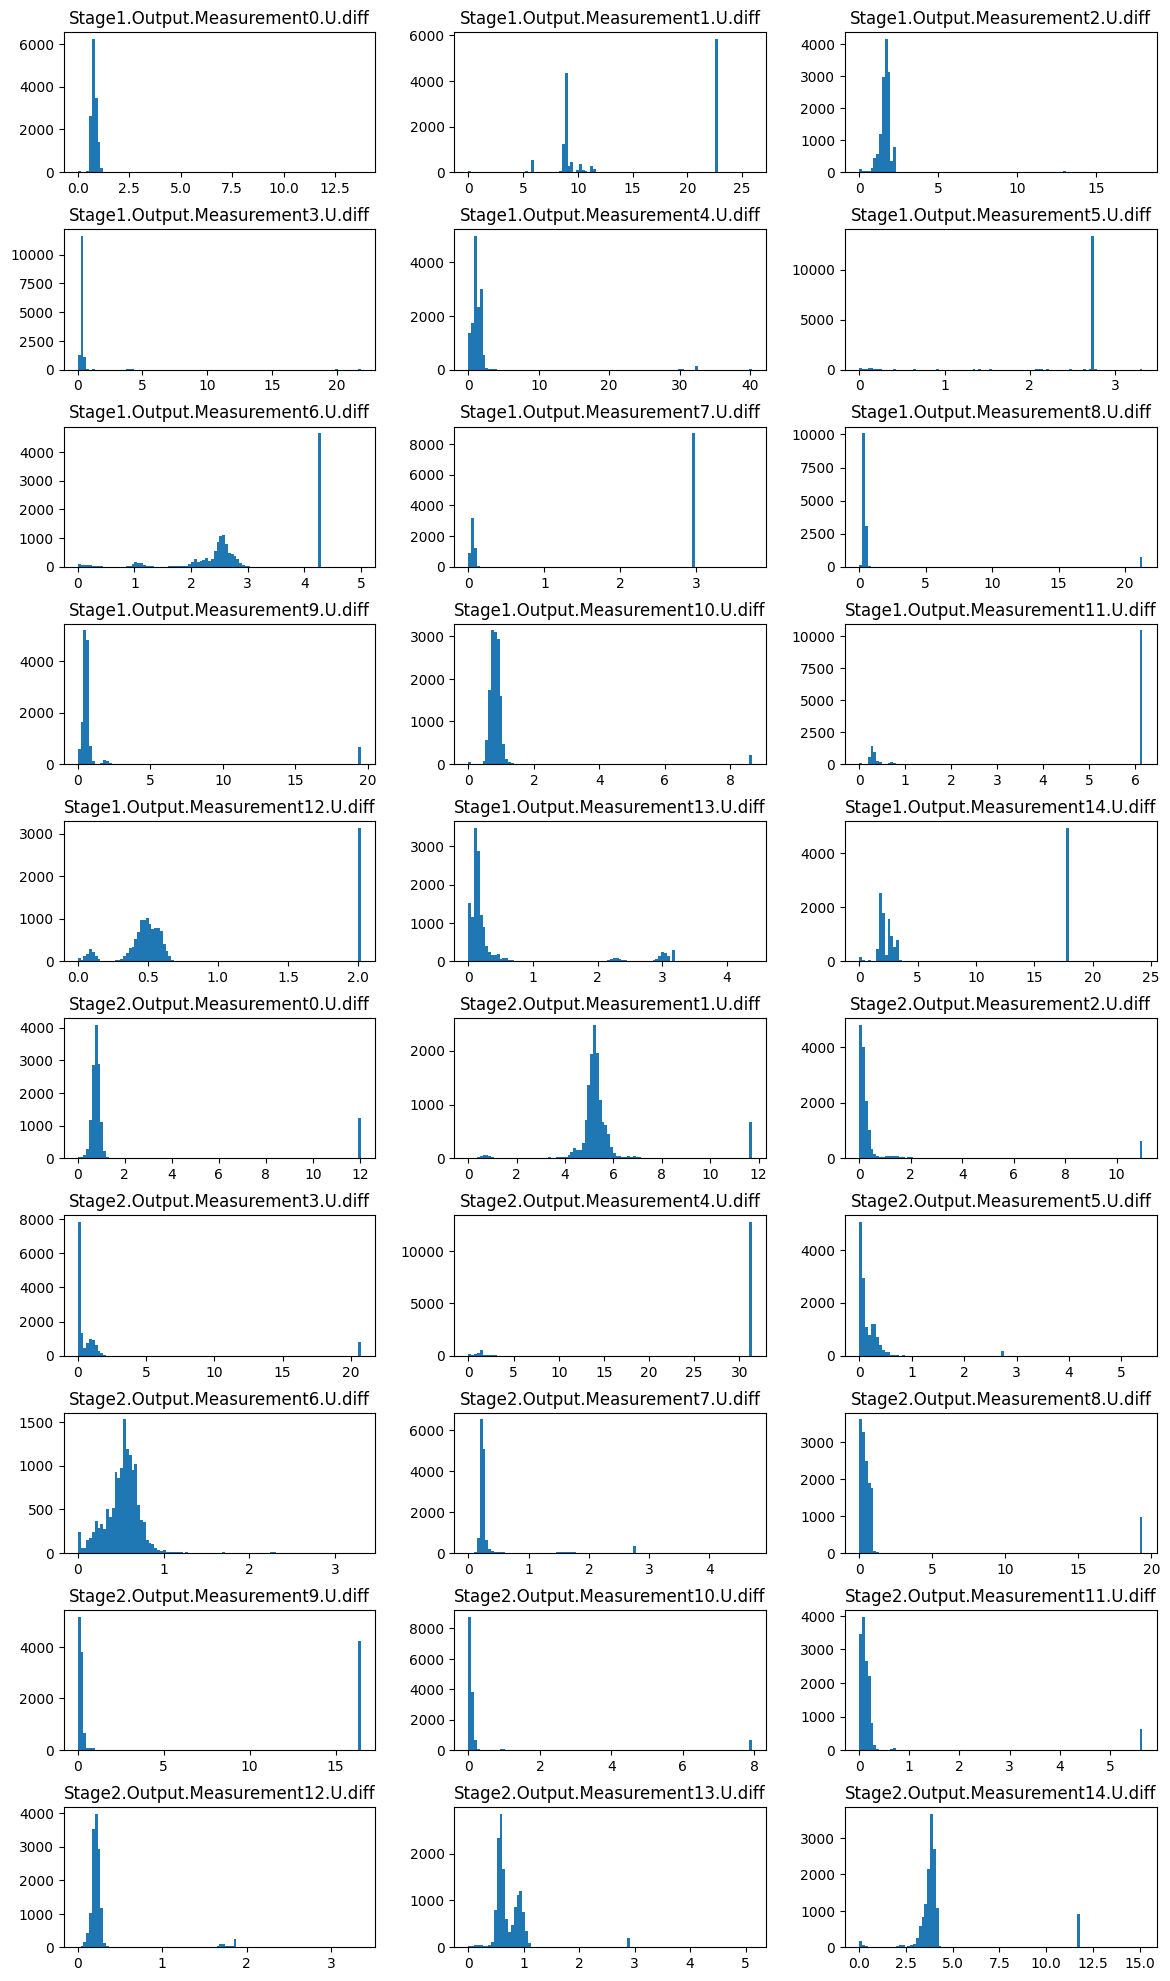

In [20]:
# Let's create a series of histograms for the newly created "diff" feature

# setup figure
rows = 10
cols = 3
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12,20))
fig.tight_layout(pad=2.0)

i = 0
for r in range(rows):
    for c in range(cols):
        # set titles
        base_name = col_pairs[i][0][0:-len("Actual")]
        col_name = base_name + "diff"
        plot_title = col_name   
        ax[r][c].set_title(plot_title)        
        # create histogram
        ax[r][c].hist(df[col_name], bins=100)

        i += 1


We would have liked to see a single peak close to zero, instead we observe multimodality and peaks centered off zero and some extreme values.

Notice also, how many histograms have a single extreme bin with a high number of counts. That bin corresponds to the drop from the setpoint/targe value to zero.

So, very likely those drops to zero should be treated as outliers. The interpretation of those outliers is that it is a measurement error where the machine did not transmit the data, so the recorded value was "zero". Thus, the value of "Zero" is not a measurement, and can potentially be replaced by the "median" of the dataset in question.

In [21]:
# Let's look at the medians of the "Diff" feature to see which parameters tend to deviate the most from "zero" in absolute terms.

# Let's divide the diff columns between Stage1 and Stage2
diff_cols_1 = []
diff_cols_2 = []
for col in df.columns:
    if col.startswith("Stage1") and col.endswith("diff"):
        diff_cols_1 += [col]
    elif col.startswith("Stage2") and col.endswith("diff"):
        diff_cols_2 += [col]
    else:
        pass

df_offset_1 = pd.DataFrame()
df_offset_2 = pd.DataFrame()
df_offset_1["Stage1_median"] = df[diff_cols_1].median()
df_offset_1["Stage1_var"] = df[diff_cols_1].var()
df_offset_2["Stage2_median"] = df[diff_cols_2].median()
df_offset_2["Stage2_var"] = df[diff_cols_2].var()

df_offset = pd.concat([df_offset_1, df_offset_2], axis =1)
#df_offset.reset_index(inplace = True)
df_offset

,Stage1_median,Stage1_var,Stage2_median,Stage2_var
Stage1.Output.Measurement0.U.diff,0.780,0.199243,NaN,NaN
Stage1.Output.Measurement1.U.diff,9.475,48.261851,NaN,NaN
Stage1.Output.Measurement2.U.diff,1.710,0.416088,NaN,NaN
Stage1.Output.Measurement3.U.diff,0.370,2.632593,NaN,NaN
Stage1.Output.Measurement4.U.diff,1.010,8.816082,NaN,NaN
Stage1.Output.Measurement5.U.diff,2.740,0.325430,NaN,NaN
Stage1.Output.Measurement6.U.diff,2.610,1.154131,NaN,NaN
Stage1.Output.Measurement7.U.diff,2.970,1.999225,NaN,NaN
Stage1.Output.Measurement8.U.diff,0.400,21.360974,NaN,NaN
Stage1.Output.Measurement9.U.diff,0.570,16.330665,NaN,NaN


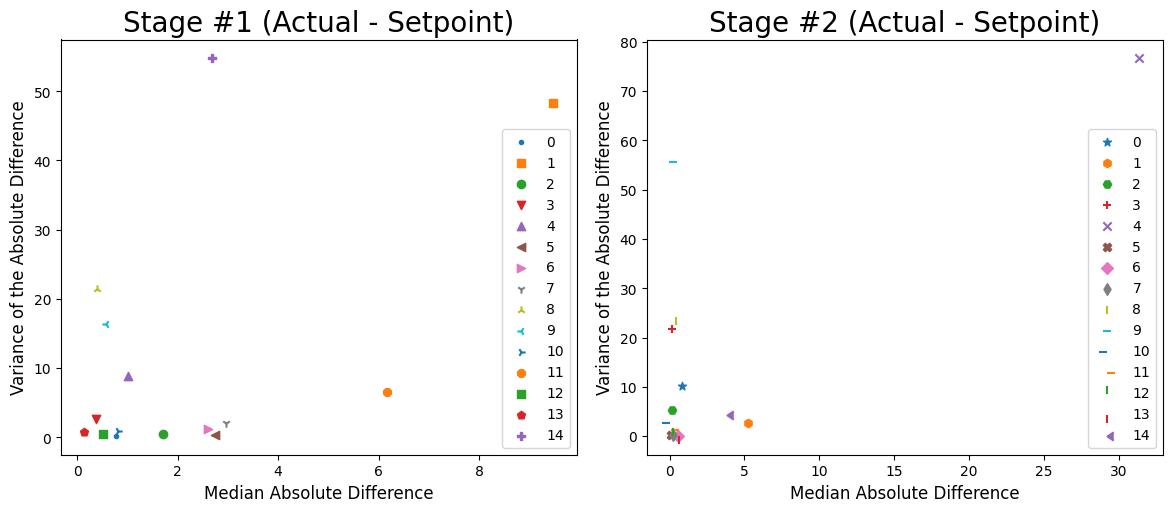

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.tight_layout(pad=2.0)

marker_lst = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]

for i in range(0,15,1):
    ax[0].scatter(x = df_offset.iloc[i,0], y = df_offset.iloc[i,1], marker = marker_lst[i])
for k in range(15,30,1):
    ax[1].scatter(x = df_offset.iloc[k,2], y = df_offset.iloc[k,3], marker = marker_lst[k])

titles = []
for l in range(0,2,1):
    ax[l].legend(list(range(0, 15, 1)), bbox_to_anchor=(1,0), loc="lower right")
    ax[l].set_xlabel("Median Absolute Difference", size=12)
    ax[l].set_ylabel("Variance of the Absolute Difference", size=12)
    ax[l].set_title("Stage #" + str(l+1) + " (Actual - Setpoint)", size=20)

### Conclusion
> - The process is far from optimized, there is typically quite a large difference between Setpoint and Actual values.
> - The "Actual" values show a significant noise, typically populated by spike andd step events
> - It seems that in **Stage #1**, some of the worst perfomance is associated with measurements 1, 11 and 14, while in **Stage #2** measurements 4 and 9 are show exceptional high levels of deviation.

## Controlled Machine Variables

The process involves various machines which run at conditions that can be either Controlled (C) or Uncontrolled (U). While the uncontrolled conditions can stem from environmental variables, or supply material properties that the line operators cannot really influence, they can however run the machines at different operating conditions - such as temperature or speed, for example - which they can control. Both controll and uncontrolled variables can potentially influence the outcome. Let's have a look at how they perfrom.

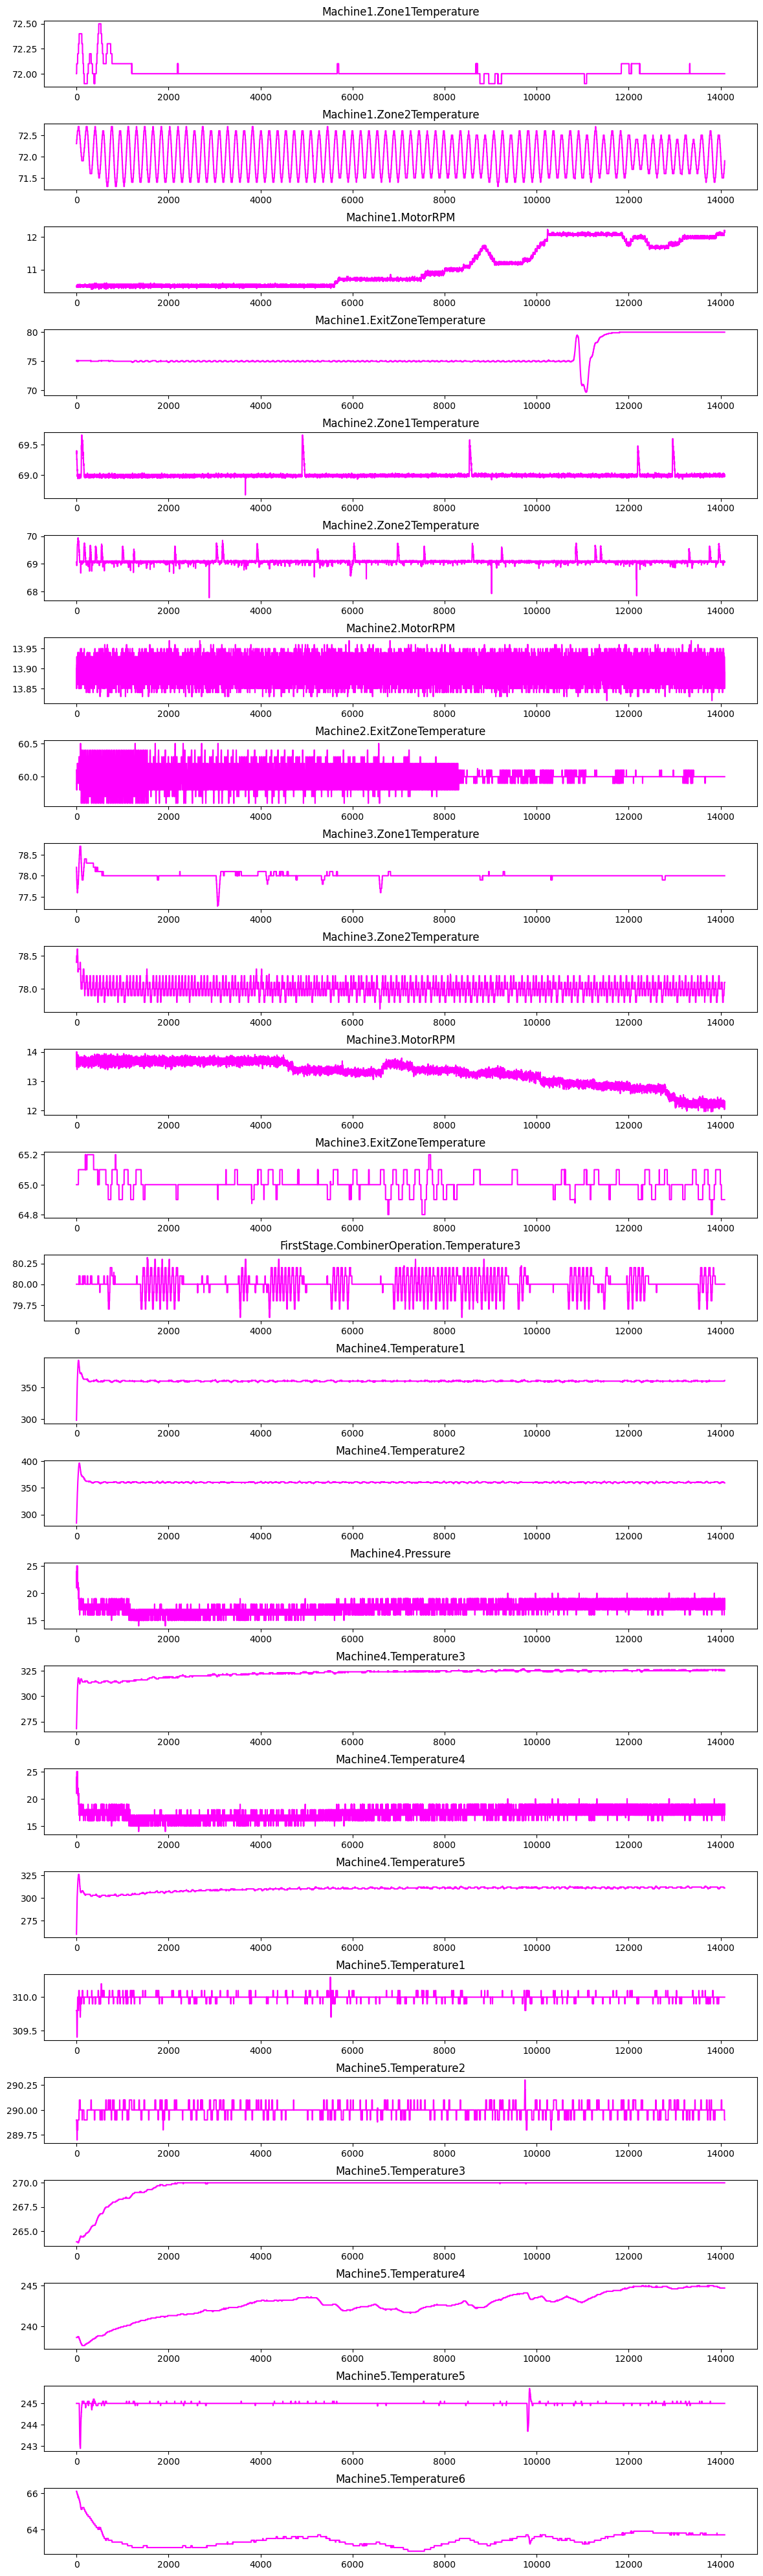

In [23]:
lst_ctrl_var = []
for col in df.columns:
    if col.endswith(".C.Actual"):
        lst_ctrl_var += [col]

fig, ax = plt.subplots(nrows = len(lst_ctrl_var), ncols = 1, figsize=(12,40))
fig.tight_layout(pad=2.0)
for i, row in enumerate(ax):
    df.loc[:, lst_ctrl_var[i]].plot(c = "magenta", ax = row)
    # set titles
    plot_title = lst_ctrl_var[i][0:-len(".C.Actual")]    
    row.set_title(plot_title)
    #set legends
    #legend = ["Actual", "Setpoint"]
    #row.legend(legend, bbox_to_anchor=(1,0), loc="lower left")

## Uncontrolled Process Variables

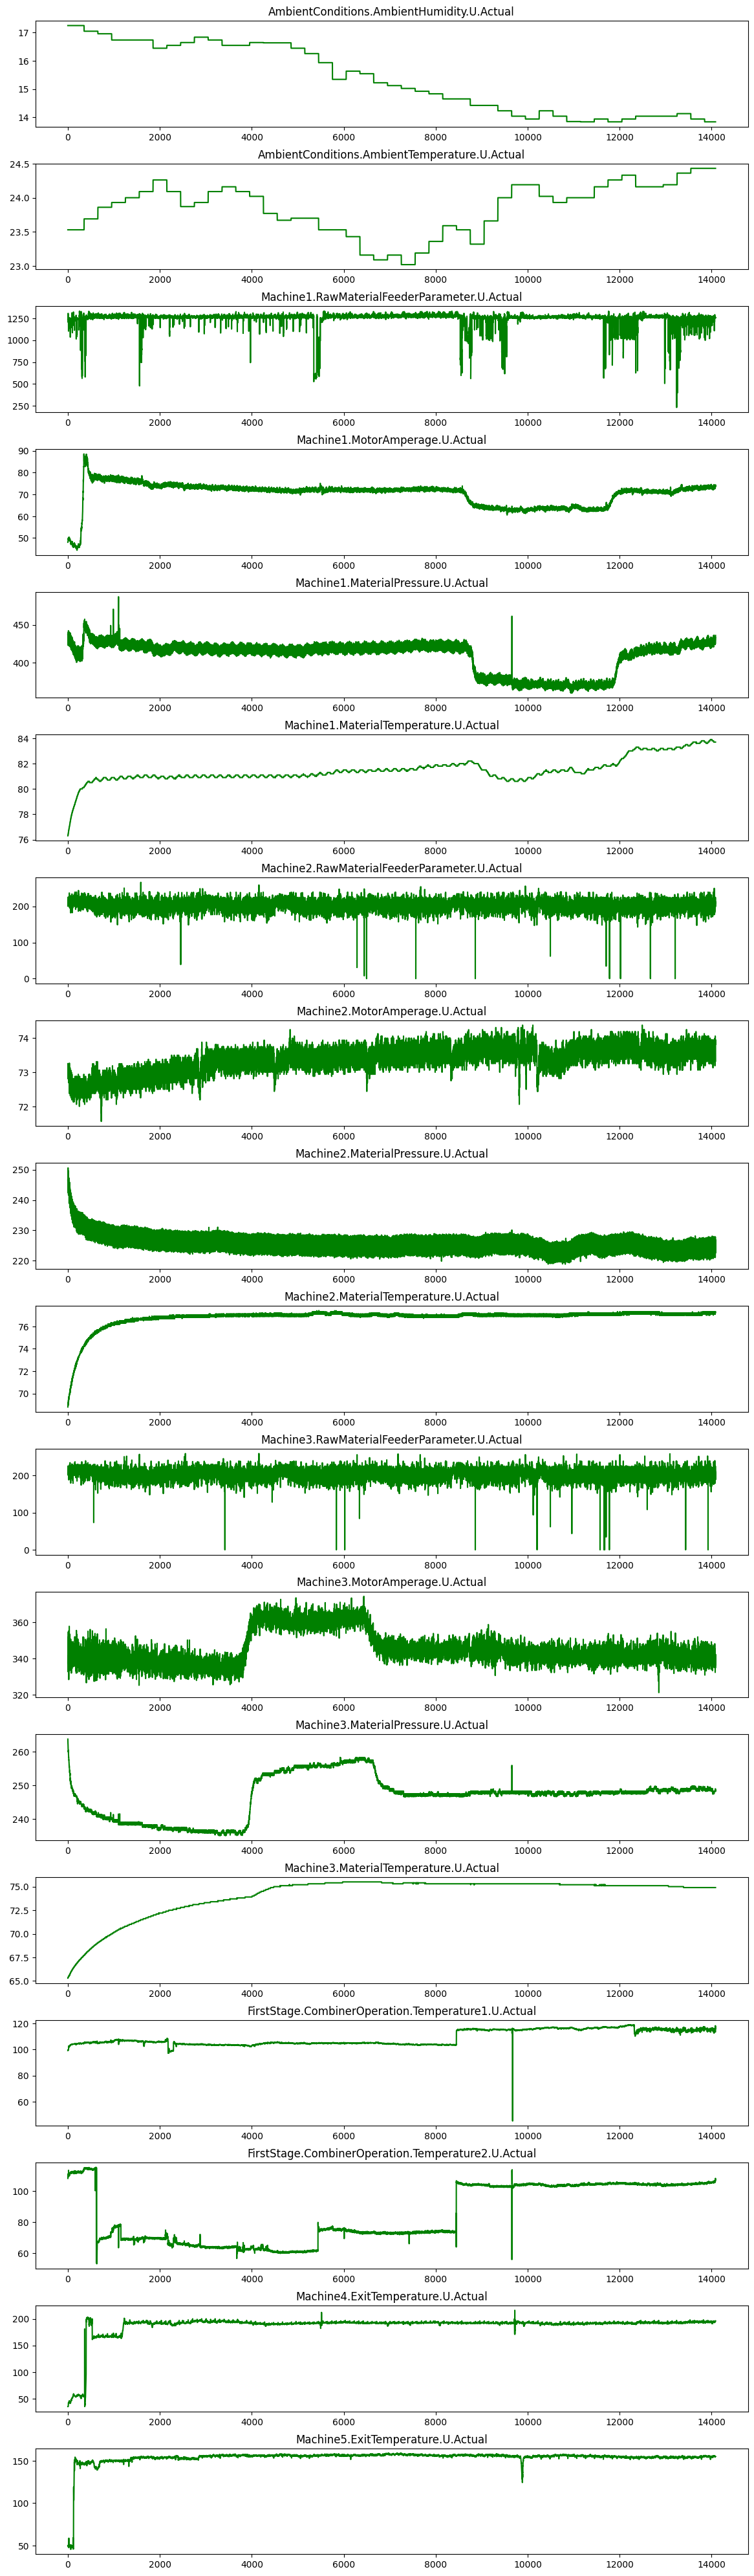

In [24]:
lst_uctrl_var = []
for col in df.columns:
    if col.startswith("Stage") == False and col.endswith(".U.Actual"):
        lst_uctrl_var += [col]

fig, ax = plt.subplots(nrows = len(lst_uctrl_var), ncols = 1, figsize=(12,40))
fig.tight_layout(pad=2.0)
for i, row in enumerate(ax):
    df.loc[:, lst_uctrl_var[i]].plot(c="green", ax = row)
    # set titles
    plot_title = lst_uctrl_var[i]#[0:-len(".U.Actual")]    
    row.set_title(plot_title)

## Conclusion

There is a lot of data, and many variables to look at.


In [25]:
# We are told the sampling rante is 1Hz, let's create two time-related features:
#     - "time_hms": displaying the incrementing time in "hours:minutes:seconds" format
#     - "time_s": displaying the incrementing time only in seconds.

# convert the column to datetime objects
df["time_stamp"] = pd.to_datetime(df["time_stamp"])

# create the new time-features:
df["time_hms"] = (df["time_stamp"] - df.loc[0,"time_stamp"])
df["time_s"] = (df["time_stamp"] - df.loc[0,"time_stamp"]) // pd.Timedelta('1s')

df.iloc[:,-2:]

,time_hms,time_s
0,0 days 00:00:00,0
1,0 days 00:00:01,1
2,0 days 00:00:02,2
3,0 days 00:00:03,3
4,0 days 00:00:04,4
...,...,...
14083,0 days 03:54:43,14083
14084,0 days 03:54:44,14084
14085,0 days 03:54:45,14085
14086,0 days 03:54:46,14086


In [26]:
# Create a dataframe that holds the 15 measurements of the primary output (cols 42 to 71)
df_output1 = df.iloc[:,42:72]
df_output1

,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement1.U.Setpoint,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement4.U.Setpoint,...,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint
0,12.72,13.75,0.0,22.74,12.16,13.02,21.97,21.88,0.00,32.55,...,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72
1,12.34,13.75,0.0,22.74,0.00,13.02,17.78,21.88,0.00,32.55,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
2,12.34,13.75,0.0,22.74,0.00,13.02,17.78,21.88,0.00,32.55,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
3,12.34,13.75,0.0,22.74,0.00,13.02,17.78,21.88,0.00,32.55,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
4,12.29,13.75,0.0,22.74,0.00,13.02,17.83,21.88,31.44,32.55,...,7.54,8.65,5.15,6.16,1.15,2.02,2.72,3.16,0.00,17.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,12.61,13.75,0.0,22.74,9.14,13.02,21.50,21.88,31.55,32.55,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14084,12.61,13.75,0.0,22.74,9.14,13.02,21.50,21.88,31.55,32.55,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14085,12.61,13.75,0.0,22.74,9.14,13.02,21.50,21.88,31.55,32.55,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14086,12.58,13.75,0.0,22.74,8.99,13.02,21.84,21.88,31.55,32.55,...,7.66,8.65,0.00,6.16,1.40,2.02,3.30,3.16,0.00,17.72
